In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import re
import arabic_reshaper

from scipy.linalg import eig

import re
from bidi.algorithm import get_display as bidi_get_display

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# === Гематрия букв иврита ===
letter_gematria = {
    "א": 1, "ב": 2, "ג": 3, "ד": 4, "ה": 5,
    "ו": 6, "ז": 7, "ח": 8, "ט": 9, "י": 10,
    "כ": 20, "ל": 30, "מ": 40, "נ": 50,
    "ס": 60, "ע": 70, "פ": 80, "צ": 90,
    "ק": 100, "ר": 200, "ש": 300, "ת": 400
}

# === Сфирот: номер → имя + значение ===
sfirot = {
    1: {"name": "כתר", "meaning": "Венец", "pos": (0, 5), "column": "центр"},
    2: {"name": "חכמה", "meaning": "Мудрость", "pos": (2, 4), "column": "правый"},
    3: {"name": "בינה", "meaning": "Понимание", "pos": (-2, 4), "column": "левый"},
    4: {"name": "חסד", "meaning": "Милосердие", "pos": (2, 3), "column": "правый"},
    5: {"name": "גבורה", "meaning": "Сила", "pos": (-2, 3), "column": "левый"},
    6: {"name": "תפארת", "meaning": "Красота", "pos": (0, 3), "column": "центр"},  
    7: {"name": "נצח", "meaning": "Победа", "pos": (2, 2), "column": "правый"},
    8: {"name": "הוד", "meaning": "Слава", "pos": (-2, 2), "column": "левый"},
    9: {"name": "יסוד", "meaning": "Основа", "pos": (0, 1), "column": "центр"},
    10: {"name": "מלכות", "meaning": "Царство", "pos": (0, 0), "column": "центр"}
}

# === Связи букв со сфирот (используем letter_gematria) ===
letter_to_sfirot = {
    "ה": {"paths": [(1, 2)], "gematria": letter_gematria["ה"], "meaning": "Кетер → Хохма"},
    "ש": {"paths": [(3, 2)], "gematria": letter_gematria["ש"], "meaning": "Бина → Хохма"},
    "ז": {"paths": [(5, 2)], "gematria": letter_gematria["ז"], "meaning": "Гвура → Хохма"},
    "ב": {"paths": [(2, 4)], "gematria": letter_gematria["ב"], "meaning": "Хохма → Хесед"},
    "א": {"paths": [(4, 5)], "gematria": letter_gematria["א"], "meaning": "Хесед → Гвура"},
    "כ": {"paths": [(4, 7)], "gematria": letter_gematria["כ"], "meaning": "Хесед → Нецах"},
    "ח": {"paths": [(4, 6)], "gematria": letter_gematria["ח"], "meaning": "Хесед → Тиферет"},
    "י": {"paths": [(7, 6)], "gematria": letter_gematria["י"], "meaning": "Нецах → Тиферет"},
    "מ": {"paths": [(7, 8)], "gematria": letter_gematria["מ"], "meaning": "Нецах → Ход"},
    "נ": {"paths": [(7, 9)], "gematria": letter_gematria["נ"], "meaning": "Нецах → Йесод"},
    "ת": {"paths": [(9, 10)], "gematria": letter_gematria["ת"], "meaning": "Йесод → Малхут"},
    "ר": {"paths": [(6, 9)], "gematria": letter_gematria["ר"], "meaning": "Тиферет → Йесод"},
    "ד": {"paths": [(1, 6)], "gematria": letter_gematria["ד"], "meaning": "Кетер → Тиферет"},
    "ל": {"paths": [(9, 8)], "gematria": letter_gematria["ל"], "meaning": "Йесод → Ход"},
    "פ": {"paths": [(5, 8)], "gematria": letter_gematria["פ"], "meaning": "Гвура → Ход"},
    "ג": {"paths": [(3, 5)], "gematria": letter_gematria["ג"], "meaning": "Бина → Гвура"},
    "ק": {"paths": [(3, 4)], "gematria": letter_gematria["ק"], "meaning": "Бина → Хесед"},
    "ע": {"paths": [(3, 6)], "gematria": letter_gematria["ע"], "meaning": "Бина → Тиферет"},
    "ו": {"paths": [(3, 1)], "gematria": letter_gematria["ו"], "meaning": "Бина → Кетер"},
    "צ": {"paths": [(5, 6)], "gematria": letter_gematria["צ"], "meaning": "Гвура → Тиферет"},
    "ס": {"paths": [(8, 6)], "gematria": letter_gematria["ס"], "meaning": "Ход → Тиферет"},
    "ט": {"paths": [(2, 6)], "gematria": letter_gematria["ט"], "meaning": "Хохма → Тиферет"},
}

In [4]:
def count_letter_frequency(text, letter_to_sfirot):
    """Считает абсолютную частоту букв (включая нулевые)"""
    freq = {char: 0 for char in letter_to_sfirot}
    for char in text:
        if char in freq:
            freq[char] += 1
    return freq

def build_sephirot_graph(letter_data, sfirot, text=None, method="log"):
    """
    Строит динамический граф сфирот на основе конкретного текста.
    
    Параметры:
    - method: "log" (лог-нормировка гематрии), 
              "adaptive" (нормировка на макс. гематрию в тексте),
              "raw" (gematria * freq без нормировки)
    """
    G = nx.Graph()

    for num, info in sfirot.items():
        G.add_node(num,
                   label=info["name"],
                   meaning=info["meaning"],
                   pos=info["pos"],
                   column=info["column"])

    if not text:
        return G

    frequencies = count_letter_frequency(text, letter_data)

    # Определяем макс. гематрию среди реально использованных букв
    used_gematrias = [
        data["gematria"] 
        for letter, data in letter_data.items() 
        if frequencies.get(letter, 0) > 0
    ]
    max_gem_in_text = max(used_gematrias) if used_gematrias else 1

    for letter, data in letter_data.items():
        paths = data.get("paths", [])
        gematria = data.get("gematria", 0)
        freq = frequencies.get(letter, 0)

        if freq == 0:
            continue

        if method == "log":
            weight = np.log(1 + gematria) * freq
        elif method == "adaptive":
            weight = (gematria / max_gem_in_text) * freq
        else:  # "raw"
            weight = gematria * freq

        for src, dst in paths:
            G.add_edge(src, dst,
                       letter=letter,
                       gematria=gematria,
                       frequency=freq,
                       weight=weight)
    return G

In [8]:
def reshape_rtl(text):
    """Перестраиваем символы под RTL"""
    reshaped_text = arabic_reshaper.reshape(text)
    return bidi_get_display(reshaped_text)


def draw_sephirot_graph(G):
    """Визуализация графа сфирот"""
    # Позиции сфирот
    pos = {
        1: (0, 2.5),     # כתר
        2: (1, 2),       # חכמה
        3: (-1, 2),      # בינה
        4: (1, 1.5),     # חסד
        5: (-1, 1.5),    # גבורה
        6: (0, 1.5),     # תפארת
        7: (1, 1),       # נצח
        8: (-1, 1),      # הוד
        9: (0, 0.5),     # יסוד
        10: (0, 0)       # מלכות
    }

    plt.figure(figsize=(8, 16))

    # Подписи узлов с поддержкой RTL
    node_labels = {n: reshape_rtl(data['label']) for n, data in G.nodes(data=True)}

    # Рисуем вершины
    nx.draw_networkx_nodes(G, pos, node_size=2800, node_color="lightgreen")
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=18, 
                           font_weight='bold', font_family='DejaVu Sans')

    # Рёбра с метками
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        label_parts = [
            f"{reshape_rtl(d['letter'])} ({d['gematria']})",
            f"частота: {d['frequency']}"
        ]
        edge_labels[(u, v)] = "\n".join(label_parts)

    nx.draw_networkx_edges(G, pos, edge_color="gray", width=1.5)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()


def clean_text(text):
    """Очистка текста: оставляем только еврейские буквы"""
    # Шаг 1: оставляем только еврейские буквы и пробелы
    cleaned = re.sub(r"[^\u05D0-\u05EA\s]", " ", text)
    
    # Шаг 2: заменяем окончательные формы букв на стандартные
    final_to_normal = {
        'ם': 'מ',  # мем софит
        'ץ': 'צ',  # цади софит
        'ן': 'נ',  # нун софит
        'ך': 'כ',  # каф софит
        'ף': 'פ'   # пе софит
    }
    cleaned = ''.join(final_to_normal.get(c, c) for c in cleaned)
    
    # Шаг 3: убираем лишние пробелы
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    return cleaned

In [9]:
text = """
אשרי תמימי דרך ההלכים בתורת יהוה
אשרי נצרי עדתיו בכל לב ידרשוהו
אף לא פעלו עולה בדרכיו הלכו
אתה צויתה פקדיך לשמר מאד
אחלי יכנו דרכי לשמר חקיך
אז לא אבוש בהביטי אל כל מצותיך
אודך בישר לבב בלמדי משפטי צדקך
את חקיך אשמר אל תעזבני עד מאד
במה יזכה נער את ארחו לשמר כדברך
בכל לבי דרשתיך אל תשגני ממצותיך
בלבי צפנתי אמרתך למען לא אחטא לך
ברוך אתה יהוה למדני חקיך
בשפתי ספרתי כל משפטי פיך
בדרך עדותיך ששתי כעל כל הון
בפקודיך אשיחה ואביטה ארחתיך
בחקתיך אשתעשע לא אשכח דברך
גמל על עבדך אחיה ואשמר דברך
גל עיני ואביטה נפלאות מתורתך
גר אנכי בארץ אל תסתיר ממני מצותיך
גרסה נפשי לתאבה אל משפטיך בכל עת
גערת זדים ארורים השגים ממצותיך
גל מעלי חרפה ובוז כי עדותיך נצרתי
גם ישבו שרים בי נדברו עבדך ישיח בחקיך
גם עדתיך שעשעי אנשי עצתי
דבקה לעפר נפשי חיני כדברך
דרכי ספרתי ותענני למדני חקיך
דרך פקדיך הבינני ואשיחה בנפלאותיך
דלפה נפשי מתוגה קימני כדברך
דרך שקר הסר ממני ותורתך חנני
דרך אמונה בחרתי משפטיך שויתי
דבקתי בעדותיך יהוה אל תבישני
דרך מצותיך ארוץ כי תרחיב לבי
הורני יהוה דרך חקיך ואצרנה עקב
הבינני ואצרה תורתך ואשמרנה בכל לב
הדריכני בנתיב מצותיך כי בו חפצתי
הט לבי אל עדותיך ואל אל בצע
העבר עיני מראות שוא בדרכך חייני
הקם לעבדך אמרתך אשר ליראתך
העבר חרפתי אשר יגרתי כי משפטיך טובים
הנה תאוויתי לפקודיך בצדקתך חייני
ויבאני חסדך יהוה תשועתך כאמרתך
ואענה חרפי דבר כי בטחתי בדברך
ואל תצל מפי דבר אמת עד מאד כי למשפטך יחלתי
ואשמר תורתך תמיד לעולם ועד
ואתהלכה ברחבה כי פקודיך דרשתי
ואדברה בעדתיך נגד מלכים ולא אבוש
ואשתעשע במצותיך אשר אהבתי
ואשא כפי אל מצותיך אשר אהבתי ואשיחה בחקיך
זכר דברך לעבדך על אשר יחלתני
זאת נחמתי בעניי כי אמרתך חיתני
זדים הליצוני עד מאד מתורתך לא נטיתי
זכרתי משפטיך מעולם יהוה ואתנחם
זלעפה אחזתני מרשעים עוזבי תורתך
זמרות היו לי חקיך בבית מגורי
זכרתי בלילה שמך יהוה ואשמר תורתך
זאת היתה לי כי פקודיך נצרתי
חלקי יהוה אמרתי לשמר דבריך
חליתי פניך בכל לב חנני כאמרתך
חשבתי דרכי ואשיבה רגלי אל עדותיך
חשתי ולא התמהמהתי לשמר מצותיך
חבלי רשעים עודני תורתך לא שכחתי
חצות לילה אקום להודות לך על משפטי צדקך
חבר אני לכל אשר יראוך ולשמרי פקודיך
חסדך יהוה מלאה הארץ חקיך למדני
טוב עשית עם עבדך יהוה כדברך
טוב טעם ודעת למדני כי במצותיך האמנתי
טרם אענה אני שגג ועתה אמרתך שמרתי
טוב אתה ומטיב למדני חקיך
טפלו עלי שקר זדים אני בכל לב אצר פקודיך
טפש כחלב לבם אני תורתך שעשעתי
טוב לי כי עניתי למען אלמד חקיך
טוב לי תורת פיך מאלפי זהב וכסף
ידיך עשוני ויכוננוני הבינני ואלמד מצותיך
יראיך יראוני וישמחו כי לדברך יחלתי
ידעתי יהוה כי צדק משפטיך ואמונה עניתני
יהי חסדך לנחמני כאמרתך לעבדך
יבאוני רחמיך ואחיה כי תורתך שעשעי
יבשו זדים כי שקר עוותוני אני אשיח בפקודיך
ישובו לי יראיך וידעו עדתיך
יהי לבי תמים בחקיך למען לא אבוש
כלתה לתשועתך נפשי לדברך יחלתי
כלו עיני לדברך אמרתי מתי תנחמני
כי הייתי כנאד בקיטור חקיך לא שכחתי
כמה ימי עבדך מתי תעשה ברדפי משפט
כרו לי זדים שחות אשר לא כתורתך
כל מצותיך אמונה שקר רדפוני עזרני
כמעט כלוני בארץ ואני לא עזבתי פקודיך
כחסדך חייני ואשמר עדות פיך
לעלם יהוה דברך נצב בשמים
לדר ודר אמונתך כוננת ארץ ותעמד
למשפטיך עמדו היום כי הכל עבדיך
לולא תורתך שעשעי אז אבדתי בעניי
לעולם לא אשכח פקודיך כי בם חייתני
לך אני הושיעני כי פקודיך דרשתי
לי קוו רשעים לאבידני עדתיך אתבונן
לכל תכלה ראיתי קץ רחבה מצותך מאד
מה אהבתי תורתך כל היום היא שיחתי
מאיבי תחכמני מצותך כי לעולם היא לי
מכל מלמדי השכלתי כי עדותיך שיחה לי
מזקנים אתבונן כי פקודיך נצרתי
מכל ארח רע כליתי רגלי למען אשמר דברך
ממשפטיך לא סרתי כי אתה הורתני
מה נמלצו לחכי אמרתך מדבש לפי
מפקודיך אתבונן על כן שנאתי כל ארח שקר
נר לרגלי דברך ואור לנתיבתי
נשבעתי ואקימה לשמר משפטי צדקך
נעניתי עד מאד יהוה חייני כדברך
נדבות פי רצה נא יהוה ומשפטיך למדני
נפשי בכפי תמיד ותורתך לא שכחתי
נתנו רשעים פח לי ומפקודיך לא תעיתי
נחלתך עדותיך לעולם כי ששון לבי המה
נטיתי לבי לעשות חקיך לעולם עקב
סעפים שנאתי ותורתך אהבתי
סתרי ומגני אתה לדברך יחלתי
סורו ממני מרעים ואצרה מצות אלהי
סמכני כאמרתך ואחיה ואל תבישני משברי
סעדני ואושעה ואשעה בחקיך תמיד
סלית כל שוגים מחקיך כי שקר תרמיתם
סגים השבת כל רשעי ארץ לכן אהבתי עדתיך
סמר מפחדך בשרי וממשפטיך יראתי
עשיתי משפט וצדק בל תניחני לערציי
ערב עבדך לטוב אל יעשקני זדים
עיני כלו לישועתך ולאמרת צדקך
עשה עם עבדך כחסדך וחקיך למדני
עבדך אני הבינני ואדעה עדותיך
עת לעשות ליהוה הפרו תורתך
על כן אהבתי מצותיך מזהב ומפז
על כן כל פקודי כל ישרתי כל ארח שקר שנאתי
פלאות עדתיך על כן נצרתה נפשי
פתח דבריך יאיר מבין פתיים
פי פערתי ואשאפה כי למצוותיך אהבתי
פנה אלי וחנני כמשפט לאוהבי שמך
פעמי הכין באמרתך ואל תשלט בי כל און
פדני מעשק אדם ואשמר פקודיך
פני האר בעבדך ולמדני את חקיך
פלגי מים ירדו עיני על לא שמרו תורתך
צדיק אתה יהוה וישר משפטיך
צויתה צדק עדתיך ואמונה מאד
צמתתני קנאתי כי שכחו דבריך צרי
צרוף אמרתך מאד ועבדך אהבה
צעיר אנכי ונבזה פקודיך לא שכחתי
צדקתך צדק לעולם ותורתך אמת
צר וצוקה מצאוני מצותיך שעשעי
צדקת עדותיך לעולם הבינני ואחיה
קראתי בכל לב ענני יהוה חקיך אצרה
קראתיך הושיעני ואשמר עדותיך
קדמתי בנשף ואשועה לדברך יחלתי
קדמו עיני אשמרות לשיח באמרתך
קולי שמע כחסדך יהוה כמשפטך חייני
קרבו רדפי זמה מתורתך רחקו
קרוב אתה יהוה וכל מצותיך אמת
קדם ידעתי מעדתיך כי לעולם יסדתם
ראה עניי וחלצני כי תורתך לא שכחתי
ריבה ריבי וגאלני לאמרתך חייני
רחק מרשעים תשועה כי חקיך לא דרשו
רחים רחמיך יהוה כמשפטיך חייני
רבים רדפי וצרי מעדותיך לא נטיתי
ראה בוגדים ואתקוטטה אשר אמרתך לא שמרו
ראה כי פקדיך אהבתי יהוה כרחמיך חייני
ראש דברך אמת ולעולם כל משפט צדקך
שרים רדפוני חנם ומדבריך פחד לבי
שש אנכי על אמרתך כמוצא שלל רב
שקר שנאתי ואתעבה תורתך אהבתי
שבע ביום הללתיך על משפטי צדקך
שלום רב לאוהבי תורתך ואין למו מכשול
שברתי לישועתך יהוה ומצותיך עשיתי
שמרה נפשי עדתיך ואהבם מאד
שמרתי פקדיך ועדתיך כי כל דרכי נגדך
תקרב רנתי לפניך יהוה כדברך הבינני
תבוא תחנתי לפניך כח דברך הצילני
תבענה שפתי תהלה כי תלמדני חקיך
תען לשוני אמרתך כי כל מצותיך צדק
תהי ידי לעזרי כי פקדיך בחרתי
תאויתי לישועתך יהוה ותורתך שעשעי
תחי נפשי ותהללך ומשפטיך יעזרוני
תעיתי כשה אובד בקש עבדך כי מצותיך לא שכחתי"""

# Очищаем текст
text = clean_text(text)

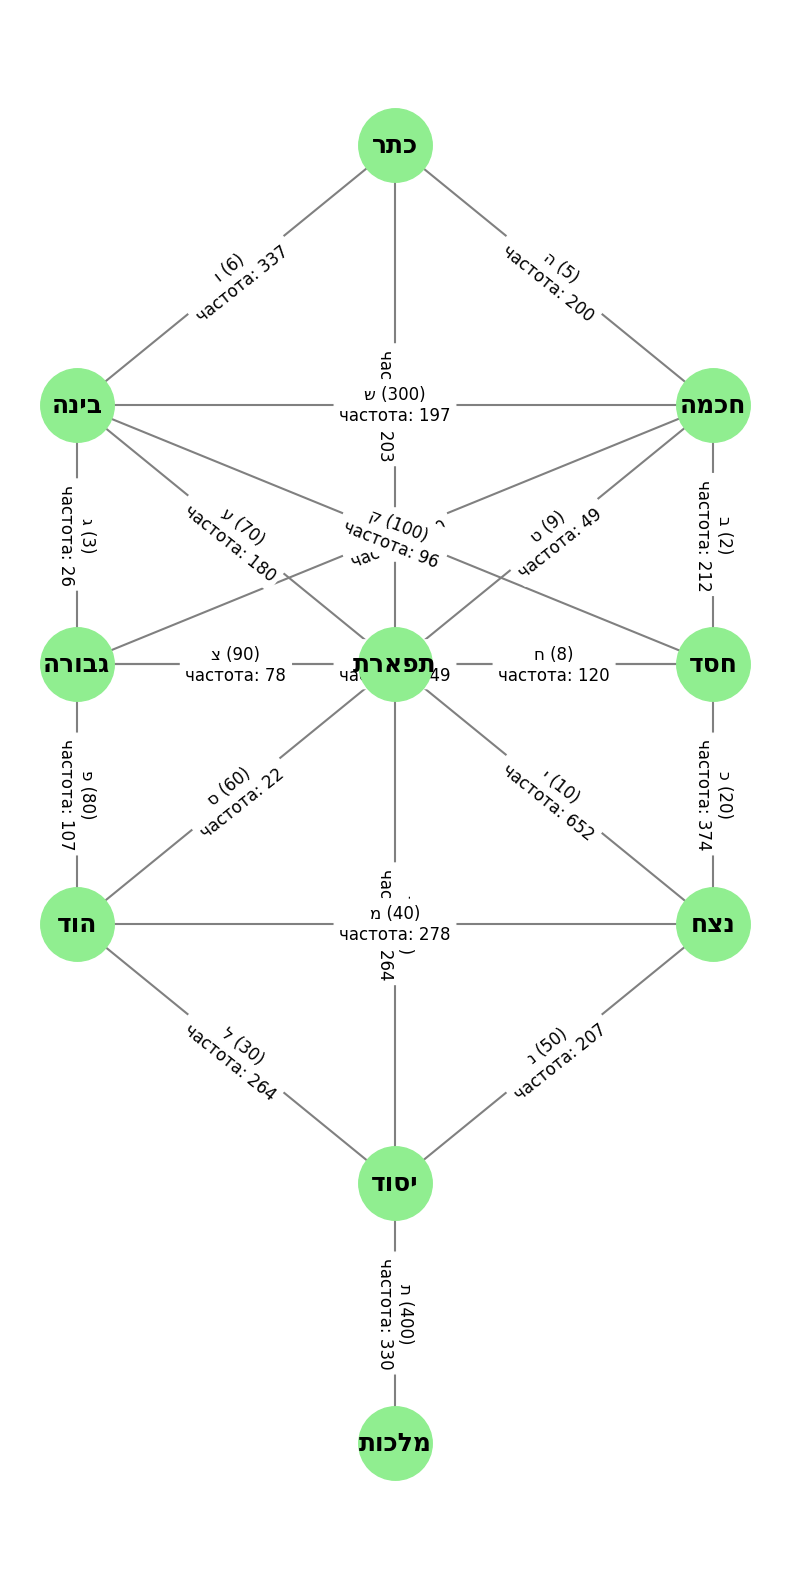

In [10]:
# Строим граф
G = build_sephirot_graph(letter_to_sfirot, sfirot, text=text, method="log")

# Визуализируем
draw_sephirot_graph(G)

## === Анализ ===

#### --- Спектральный анализ ---

In [12]:
# === 1. Разбиение очищенного текста на сегменты ===
def split_text_into_segments(text, n=6):
    """Разбивает текст на сегменты по n слов"""
    lines = [line.strip() for line in text.strip().split() if line.strip()]
    return [lines[i:i+n] for i in range(0, len(lines), n)]

segments = split_text_into_segments(text, n=191)
print(f"📊 Всего сегментов: {len(segments)}")

# === 2. Построение графов по сегментам и вычисление спектра ===
graphs = []
laplacians = []
valid_segments = []  # отслеживаем валидные сегменты

for idx, segment in enumerate(segments):
    segment_text = " ".join(segment)
    G_segment = build_sephirot_graph(letter_to_sfirot, sfirot, text=segment_text, method="log")
    
    # Проверяем, что граф не пустой
    if G_segment.number_of_edges() == 0:
        print(f"⚠️ Сегмент {idx+1} пропущен (нет рёбер)")
        continue
    
    graphs.append(G_segment)
    valid_segments.append(idx)
    L = nx.laplacian_matrix(G_segment).toarray()
    laplacians.append(L)

print(f"✅ Валидных сегментов: {len(valid_segments)}")

# Обновляем segments, оставляя только валидные
segments = [segments[i] for i in valid_segments]

# === 3. Спектральные признаки сегментов ===
eigenvalues_list = [np.linalg.eigvalsh(L) for L in laplacians]

# Находим максимальную размерность (количество узлов в графе)
max_dim = max(len(ev) for ev in eigenvalues_list)

# Дополняем собственные значения нулями для одинаковой размерности
eigenvalues_padded = []
for eigenvals in eigenvalues_list:
    padded = np.zeros(max_dim)
    padded[:len(eigenvals)] = eigenvals
    eigenvalues_padded.append(padded)

eigenvalues_array = np.array(eigenvalues_padded)
avg_eigenvalues = np.mean(eigenvalues_array, axis=0)
total_variance = np.sum(avg_eigenvalues)
cumulative_variance = np.cumsum(avg_eigenvalues)

# Определяем k для 90% объясненной дисперсии
k = np.argmax(cumulative_variance / total_variance >= 0.9) + 1
k = min(k, max_dim)  # не больше максимальной размерности

print(f"📈 Выбрано {k} главных компонент (90% дисперсии)")

# Формируем признаковое пространство
X = np.array([eigenvals[:k] for eigenvals in eigenvalues_padded])
sim_matrix = cosine_similarity(X)

# === 4. Кластеризация сегментов ===
if len(segments) < 2:
    print("⚠️ Недостаточно сегментов для кластеризации")
else:
    # Строим полный граф для определения оптимального числа кластеров
    G_total = build_sephirot_graph(letter_to_sfirot, sfirot, text=text, method="log")
    L_total = nx.laplacian_matrix(G_total).toarray()
    eigenvalues_total = np.sort(np.linalg.eigvalsh(L_total))
    gaps = np.diff(eigenvalues_total)
    optimal_k = np.argmax(gaps) + 1
    optimal_k = max(2, min(optimal_k, len(segments) - 1))  # от 2 до n-1
    
    print(f"🎯 Оптимальное число кластеров: {optimal_k}")

    # Спектральная кластеризация
    sc_segment = SpectralClustering(
        n_clusters=optimal_k,
        affinity='precomputed',
        assign_labels='discretize',
        random_state=42
    )
    segment_labels = sc_segment.fit_predict(sim_matrix)

    # === 5. Группировка сегментов в фазы ===
    cluster_sequences = [[] for _ in range(optimal_k)]
    for i, label in enumerate(segment_labels):
        cluster_sequences[label].append(i)

    # Сортируем кластеры по первому появлению
    cluster_order = sorted(range(optimal_k), 
                          key=lambda x: min(cluster_sequences[x]) if cluster_sequences[x] else float('inf'))

    # Группируем последовательные сегменты одного кластера
    text_segments_by_phase = []
    current_cluster = None
    current_group = []

    for i in range(len(segments)):
        label = segment_labels[i]
        if current_cluster is not None and label != current_cluster:
            text_segments_by_phase.append({
                'cluster': current_cluster,
                'segments': current_group
            })
            current_group = []
        current_group.append(i)
        current_cluster = label

    if current_group:
        text_segments_by_phase.append({
            'cluster': current_cluster,
            'segments': current_group
        })

    # === 6. Вывод результатов ===
    print("\n" + "="*60)
    print("📘 ФАЗЫ ТЕКСТА ПО КЛАСТЕРАМ (в хронологическом порядке)")
    print("="*60)
    
    for idx, phase in enumerate(text_segments_by_phase):
        cluster_id = phase['cluster']
        segs = phase['segments']
        print(f"\n🔹 Фаза {idx+1} → Кластер {cluster_id} (сегментов: {len(segs)})")
        
        for s in segs:
            # Показываем первые 3 слова из сегмента
            preview = " ".join(segments[s][:3])
            if len(segments[s]) > 3:
                preview += "..."
            print(f"  • Сегмент {s+1}: {preview}")
    
    # === 7. Статистика по кластерам ===
    print("\n" + "="*60)
    print("📊 СТАТИСТИКА ПО КЛАСТЕРАМ")
    print("="*60)
    
    for cluster_id in range(optimal_k):
        cluster_segs = [i for i, label in enumerate(segment_labels) if label == cluster_id]
        print(f"\nКластер {cluster_id}: {len(cluster_segs)} сегментов")
        print(f"  Позиции: {cluster_segs[:5]}{'...' if len(cluster_segs) > 5 else ''}")

📊 Всего сегментов: 6
✅ Валидных сегментов: 6
📈 Выбрано 10 главных компонент (90% дисперсии)
🎯 Оптимальное число кластеров: 5

📘 ФАЗЫ ТЕКСТА ПО КЛАСТЕРАМ (в хронологическом порядке)

🔹 Фаза 1 → Кластер 2 (сегментов: 1)
  • Сегмент 1: אשרי תמימי דרכ...

🔹 Фаза 2 → Кластер 3 (сегментов: 1)
  • Сегмент 2: הבינני ואצרה תורתכ...

🔹 Фаза 3 → Кластер 0 (сегментов: 1)
  • Сегмент 3: יהוה כדברכ טוב...

🔹 Фаза 4 → Кластер 4 (сегментов: 1)
  • Сегмент 4: אתבוננ לכל תכלה...

🔹 Фаза 5 → Кластер 1 (сегментов: 1)
  • Сегмент 5: כנ אהבתי מצותיכ...

🔹 Фаза 6 → Кластер 4 (сегментов: 1)
  • Сегмент 6: אהבתי יהוה כרחמיכ...

📊 СТАТИСТИКА ПО КЛАСТЕРАМ

Кластер 0: 1 сегментов
  Позиции: [2]

Кластер 1: 1 сегментов
  Позиции: [4]

Кластер 2: 1 сегментов
  Позиции: [0]

Кластер 3: 1 сегментов
  Позиции: [1]

Кластер 4: 2 сегментов
  Позиции: [3, 5]


In [20]:
def compute_baseline_activity(letter_to_sfirot, sfirot, corpus_texts):
    """
    Вычисляет базовую активность сфирот на корпусе текстов.
    Это аналог IDF в TF-IDF.
    """
    baseline_degrees = {i: 0 for i in range(1, 11)}
    
    for text in corpus_texts:
        G = build_sephirot_graph(letter_to_sfirot, sfirot, text=text, method="log")
        if G.number_of_edges() == 0:
            continue
        degrees = dict(G.degree(weight='weight'))
        for node, deg in degrees.items():
            baseline_degrees[node] += deg
    
    # Нормализуем
    total = sum(baseline_degrees.values())
    if total > 0:
        baseline_degrees = {k: v/total for k, v in baseline_degrees.items()}
    
    return baseline_degrees


def get_top_sfirot_tfidf(G, sfirot_map, baseline_activity, top_n=5):
    """
    Возвращает топ-N сфирот с учетом TF-IDF подобной нормализации.
    
    TF = активность сфироты в текущем тексте
    IDF = обратная базовая частотность (чем реже сфирота в целом, тем выше вес)
    """
    if G.number_of_edges() == 0:
        return []
    
    degrees = dict(G.degree(weight='weight'))
    total_activity = sum(degrees.values())
    
    # Вычисляем TF-IDF скор
    tfidf_scores = {}
    for node, deg in degrees.items():
        tf = deg / total_activity if total_activity > 0 else 0
        idf = 1 / (baseline_activity.get(node, 0.1) + 1e-6)  # избегаем деления на 0
        tfidf_scores[node] = tf * idf
    
    sorted_scores = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    
    result = []
    for s, score in sorted_scores[:top_n]:
        if s in sfirot_map:
            name = sfirot_map[s]['name'].strip()
            meaning = sfirot_map[s]['meaning']
            raw_degree = degrees[s]
            result.append((name, meaning, raw_degree, score))
        else:
            result.append((f"Неизвестная сфира {s}", "—", 0, score))
    
    return result


# === Использование ===
# Шаг 1: Вычисляем базовую активность на всем тексте или корпусе
# Здесь используем сам анализируемый текст как базу, но лучше использовать большой корпус
corpus_texts = [text]  # или список разных текстов
baseline_activity = compute_baseline_activity(letter_to_sfirot, sfirot, corpus_texts)

print("📊 Базовая активность сфирот:")
for i in range(1, 11):
    print(f"  {sfirot[i]['meaning']}: {baseline_activity.get(i, 0):.4f}")

# Шаг 2: Анализируем фазы с TF-IDF
print("\n" + "="*70)
print("🌟 ТОП-3 СФИРОТ ПО ФАЗАМ (TF-IDF подход)")
print("="*70)

for idx, phase in enumerate(text_segments_by_phase):
    cluster_id = phase['cluster']
    segs = phase['segments']
    
    print(f"\n🔹 Фаза {idx+1} → Кластер {cluster_id} (сегментов: {len(segs)})")
    
    phase_words = [word for seg_idx in segs for word in segments[seg_idx]]
    phase_text = " ".join(phase_words)
    
    G_phase = build_sephirot_graph(letter_to_sfirot, sfirot, text=phase_text, method="log")
    
    if G_phase.number_of_edges() == 0:
        print("  ⚠️ Недостаточно данных для анализа")
        continue
    
    top_sfirot = get_top_sfirot_tfidf(G_phase, sfirot, baseline_activity, top_n=3)
    
    if not top_sfirot:
        print("  ⚠️ Сфирот не обнаружены")
        continue
    
    print("  🌟 Топ-3 сфирот (специфичные для этой фазы):")
    for rank, (name, meaning, raw_deg, tfidf_score) in enumerate(top_sfirot, 1):
        name_display = reshape_rtl(name)
        print(f"    {rank}. {name_display} ({meaning})")
        print(f"       • Активность: {raw_deg:.2f} | Специфичность: {tfidf_score:.4f}")

📊 Базовая активность сфирот:
  Венец: 0.0469
  Мудрость: 0.0661
  Понимание: 0.1058
  Милосердие: 0.0787
  Сила: 0.0382
  Красота: 0.1705
  Победа: 0.1590
  Слава: 0.0874
  Основа: 0.1783
  Царство: 0.0692

🌟 ТОП-3 СФИРОТ ПО ФАЗАМ (TF-IDF подход)

🔹 Фаза 1 → Кластер 2 (сегментов: 1)
  🌟 Топ-3 сфирот (специфичные для этой фазы):
    1. הרובג (Сила)
       • Активность: 218.05 | Специфичность: 1.1490
    2. המכח (Мудрость)
       • Активность: 360.11 | Специфичность: 1.0970
    3. דסח (Милосердие)
       • Активность: 410.38 | Специфичность: 1.0501

🔹 Фаза 2 → Кластер 3 (сегментов: 1)
  🌟 Топ-3 сфирот (специфичные для этой фазы):
    1. תוכלמ (Царство)
       • Активность: 407.59 | Специфичность: 1.1461
    2. דוסי (Основа)
       • Активность: 975.26 | Специфичность: 1.0639
    3. רתכ (Венец)
       • Активность: 252.23 | Специфичность: 1.0462

🔹 Фаза 3 → Кластер 0 (сегментов: 1)
  🌟 Топ-3 сфирот (специфичные для этой фазы):
    1. חצנ (Победа)
       • Активность: 891.58 | Специфичност

📊 Количество фаз: 6


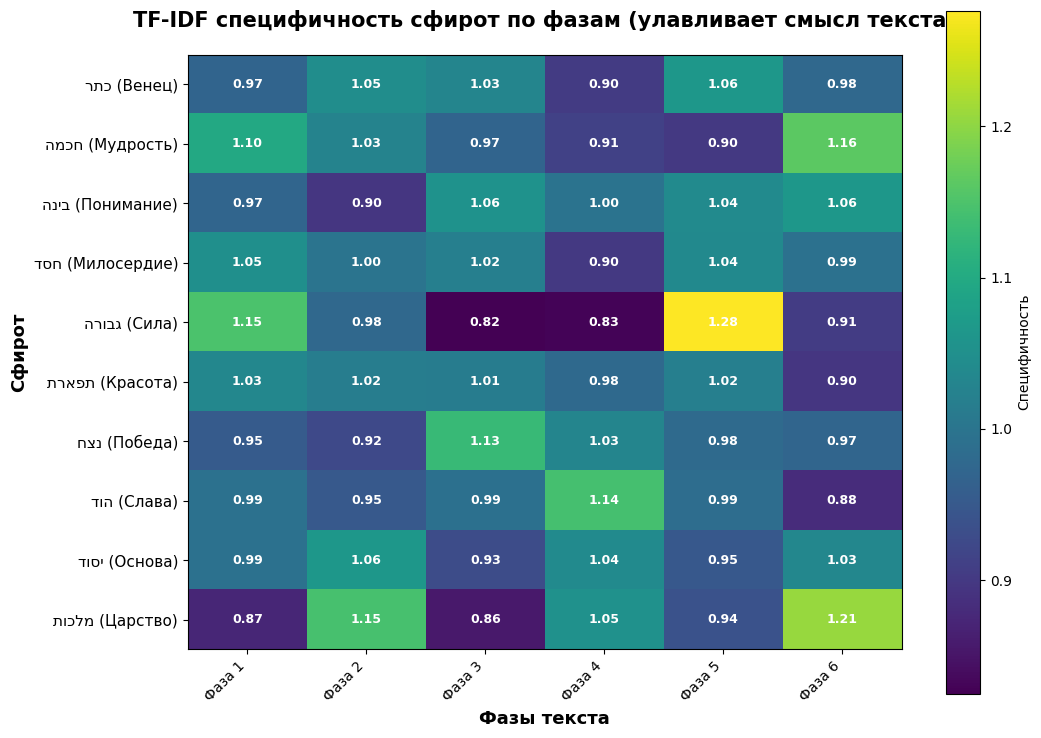


📈 Статистика визуализации:
   • Размер матрицы: 6 фаз × 10 сфирот
   • TF-IDF специфичность: мин=0.82, макс=1.28, средняя=1.00
📊 Количество фаз: 6


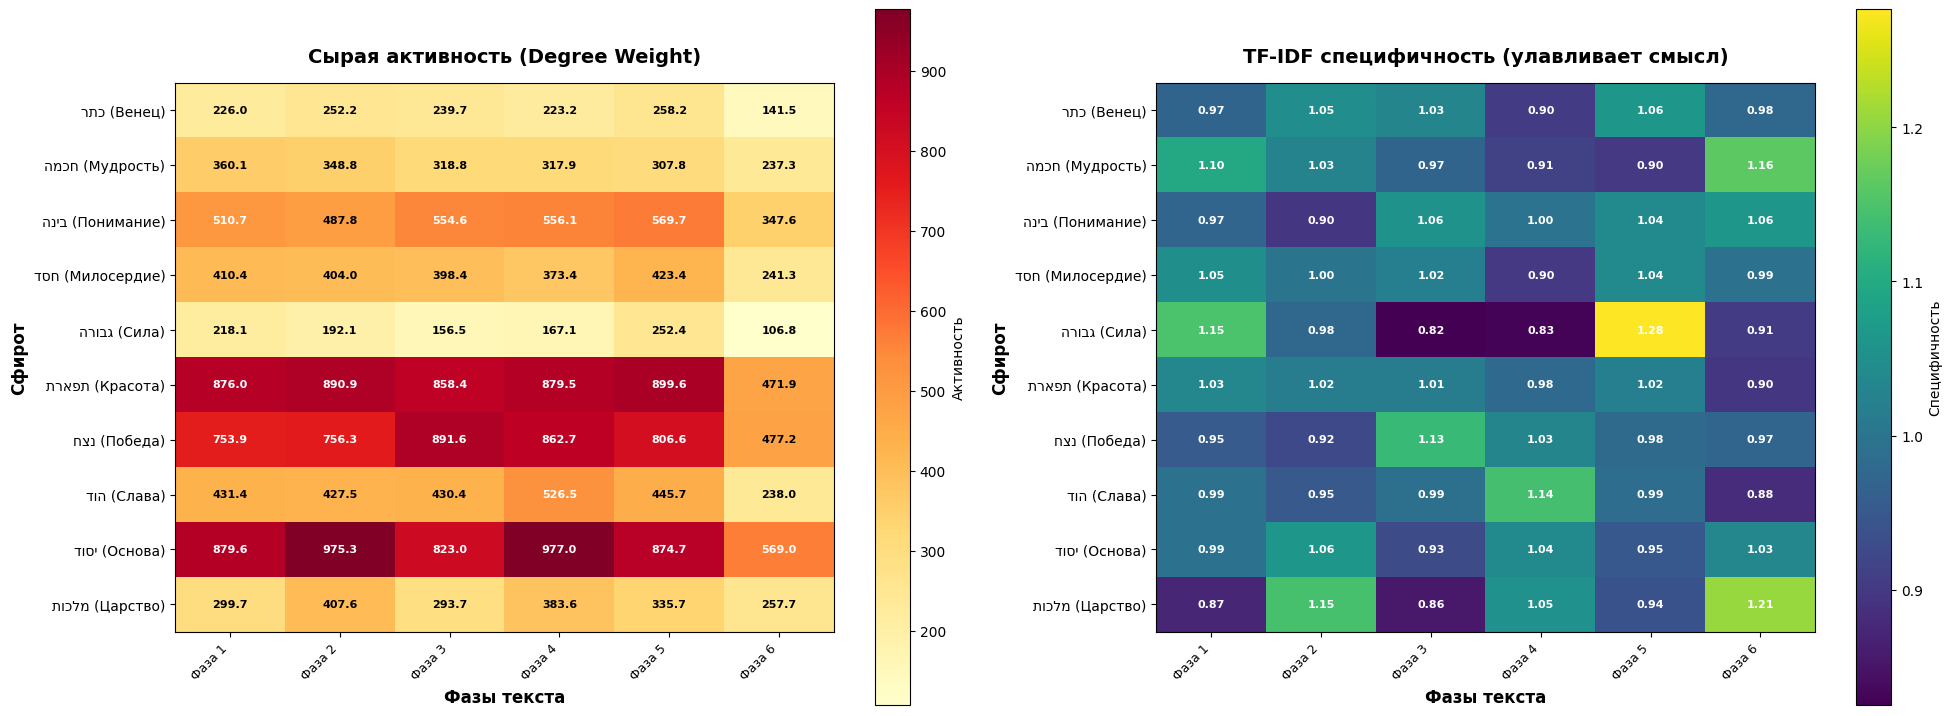


📈 Статистика визуализации:
   • Размер матрицы: 6 фаз × 10 сфирот
   • Сырая активность: мин=106.84, макс=976.96, средняя=476.71
   • TF-IDF специфичность: мин=0.82, макс=1.28, средняя=1.00


In [ ]:
def visualize_sfirot_by_phases_tfidf(text_segments_by_phase, segments, letter_to_sfirot, 
                                     sfirot, baseline_activity, metric="tfidf"):
    """
    Создает тепловую карту активности сфирот по фазам.
    
    Parameters:
    -----------
    metric : str
        "raw" - сырая активность (degree weight)
        "tfidf" - TF-IDF специфичность
        "both" - два графика рядом
    """
    sfirot_activity_raw = []
    sfirot_activity_tfidf = []
    phase_labels = []
    
    for idx, phase in enumerate(text_segments_by_phase):
        segs = phase['segments']
        phase_words = [word for seg_idx in segs for word in segments[seg_idx]]
        phase_text = " ".join(phase_words)
        
        G_phase = build_sephirot_graph(letter_to_sfirot, sfirot, text=phase_text, method="log")
        
        if G_phase.number_of_edges() == 0:
            continue
        
        # RAW активность
        degrees = dict(G_phase.degree(weight='weight'))
        activity_raw = [degrees.get(i, 0) for i in range(1, 11)]
        sfirot_activity_raw.append(activity_raw)
        
        # TF-IDF специфичность
        total_activity = sum(degrees.values())
        tfidf_values = []
        for i in range(1, 11):
            deg = degrees.get(i, 0)
            tf = deg / total_activity if total_activity > 0 else 0
            idf = 1 / (baseline_activity.get(i, 0.1) + 1e-6)
            tfidf = tf * idf
            tfidf_values.append(tfidf)
        
        sfirot_activity_tfidf.append(tfidf_values)
        phase_labels.append(f"Фаза {idx+1}")
    
    if not sfirot_activity_raw:
        print("⚠️ Нет данных для визуализации")
        return
    
    n_phases = len(sfirot_activity_raw)
    print(f"📊 Количество фаз: {n_phases}")
    
    # Формат подписей: "יסוד (Основа)"
    sfirot_labels = []
    for i in range(1, 11):
        hebrew_name = reshape_rtl(sfirot[i]['name'].strip())
        russian_name = sfirot[i]['meaning']
        label = f"{hebrew_name} ({russian_name})"
        sfirot_labels.append(label)
    
    # === Визуализация ===
    if metric == "both":
        # Два графика рядом
        fig, axes = plt.subplots(1, 2, figsize=(20, 9))
        
        # График 1: Сырая активность
        im1 = axes[0].imshow(np.array(sfirot_activity_raw).T, 
                            cmap='YlOrRd', aspect=0.5, interpolation='nearest')
        axes[0].set_title('Сырая активность (Degree Weight)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[0].set_yticks(range(10))
        axes[0].set_yticklabels(sfirot_labels, fontsize=10)
        axes[0].set_xticks(range(n_phases))
        axes[0].set_xticklabels(phase_labels, rotation=45, ha='right', fontsize=9)
        axes[0].set_xlabel('Фазы текста', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Сфирот', fontsize=12, fontweight='bold')
        plt.colorbar(im1, ax=axes[0], label='Активность', shrink=0.8)
        
        # График 2: TF-IDF специфичность
        im2 = axes[1].imshow(np.array(sfirot_activity_tfidf).T, 
                            cmap='viridis', aspect=0.5, interpolation='nearest')
        axes[1].set_title('TF-IDF специфичность (улавливает смысл)', 
                         fontsize=14, fontweight='bold', pad=15)
        axes[1].set_yticks(range(10))
        axes[1].set_yticklabels(sfirot_labels, fontsize=10)
        axes[1].set_xticks(range(n_phases))
        axes[1].set_xticklabels(phase_labels, rotation=45, ha='right', fontsize=9)
        axes[1].set_xlabel('Фазы текста', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Сфирот', fontsize=12, fontweight='bold')
        plt.colorbar(im2, ax=axes[1], label='Специфичность', shrink=0.8)
        
        # Добавляем значения в ячейки
        if n_phases <= 12:
            for i in range(n_phases):
                for j in range(10):
                    # Сырая активность
                    val1 = sfirot_activity_raw[i][j]
                    if val1 > 0:
                        color1 = 'white' if val1 > np.max(sfirot_activity_raw) * 0.5 else 'black'
                        axes[0].text(i, j, f'{val1:.1f}', 
                                   ha='center', va='center', 
                                   color=color1, fontsize=8, fontweight='bold')
                    
                    # TF-IDF
                    val2 = sfirot_activity_tfidf[i][j]
                    if val2 > 0:
                        color2 = 'white' if val2 > np.max(sfirot_activity_tfidf) * 0.5 else 'black'
                        axes[1].text(i, j, f'{val2:.2f}', 
                                   ha='center', va='center', 
                                   color=color2, fontsize=8, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Один график
        fig_width = max(10, min(20, 2 + n_phases * 1.5))
        plt.figure(figsize=(fig_width, 9))
        
        if metric == "tfidf":
            data = np.array(sfirot_activity_tfidf).T
            cmap = 'viridis'
            title = 'TF-IDF специфичность сфирот по фазам (улавливает смысл текста)'
            cbar_label = 'Специфичность'
        else:  # raw
            data = np.array(sfirot_activity_raw).T
            cmap = 'YlOrRd'
            title = 'Сырая активность сфирот по фазам'
            cbar_label = 'Активность'
        
        im = plt.imshow(data, cmap=cmap, aspect=0.5, interpolation='nearest')
        plt.colorbar(im, label=cbar_label, shrink=0.8)
        
        plt.yticks(range(10), sfirot_labels, fontsize=11)
        plt.xticks(range(n_phases), phase_labels, rotation=45, ha='right', fontsize=10)
        
        plt.xlabel('Фазы текста', fontsize=13, fontweight='bold')
        plt.ylabel('Сфирот', fontsize=13, fontweight='bold')
        plt.title(title, fontsize=15, fontweight='bold', pad=20)
        
        plt.grid(False)
        
        # Значения в ячейках
        if n_phases <= 15:
            for i in range(n_phases):
                for j in range(10):
                    value = data[j, i]
                    if value > 0:
                        text_color = 'white' if value > np.max(data) * 0.5 else 'black'
                        if metric == "tfidf":
                            plt.text(i, j, f'{value:.2f}', 
                                   ha='center', va='center', 
                                   color=text_color, fontsize=9, fontweight='bold')
                        else:
                            plt.text(i, j, f'{value:.1f}', 
                                   ha='center', va='center', 
                                   color=text_color, fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Статистика
    print(f"\n📈 Статистика визуализации:")
    print(f"   • Размер матрицы: {n_phases} фаз × 10 сфирот")
    if metric in ["raw", "both"]:
        print(f"   • Сырая активность: мин={np.min(sfirot_activity_raw):.2f}, "
              f"макс={np.max(sfirot_activity_raw):.2f}, "
              f"средняя={np.mean(sfirot_activity_raw):.2f}")
    if metric in ["tfidf", "both"]:
        print(f"   • TF-IDF специфичность: мин={np.min(sfirot_activity_tfidf):.2f}, "
              f"макс={np.max(sfirot_activity_tfidf):.2f}, "
              f"средняя={np.mean(sfirot_activity_tfidf):.2f}")


# === ИСПОЛЬЗОВАНИЕ ===

# Вариант 1: Только TF-IDF (рекомендуется)
visualize_sfirot_by_phases_tfidf(text_segments_by_phase, segments, 
                                 letter_to_sfirot, sfirot, 
                                 baseline_activity, metric="tfidf")

# Вариант 2: Сравнение двух подходов (для анализа)
visualize_sfirot_by_phases_tfidf(text_segments_by_phase, segments, 
                                 letter_to_sfirot, sfirot, 
                                 baseline_activity, metric="both")

# Вариант 3: Только сырая активность (старый подход)
# visualize_sfirot_by_phases_tfidf(text_segments_by_phase, segments, 
#                                  letter_to_sfirot, sfirot, 
#                                  baseline_activity, metric="raw")